# Speech emotion recognition using MFCC features

**Objectives:**
* Extracting MFCC features from audio signals using librosa.feature.mfcc
* Applying MFCC features to speech emotion recognition

## 1. MFCC

In this section, we will learn how to extract MFCC features using 'librosa.feature.mfcc'. You can practise MFCC features with the audio file 'arctic_a0005.wav' used in Task 7.1. Suppose that we want to extract 12 MFCC features from the cepstrum of the signal in 'arctic_a0005.wav':

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import librosa
import librosa.display
import IPython.display as ipd

from pydub import AudioSegment
from pydub.utils import mediainfo

speech = AudioSegment.from_wav('arctic_a0005.wav') #Read audio data from file
x = speech.get_array_of_samples() #samples x(t)
x_sr = speech.frame_rate #sampling rate f 

mfcc = librosa.feature.mfcc(
    np.float32(x),
    sr = x_sr, #sampling rate of the signal, which is determined from the signal
    hop_length = int(x_sr * 0.015), #15 ms
    n_mfcc = 12 #number of mfcc features
)

**librosa.feature.mfcc returns an array including 12 rows (as n_mfcc=12), and 95 columns (as hop_length is set to be equivalent to 15ms). We can check the dimension of mfcc using the following command:**

In [2]:
print(mfcc.shape)

(12, 95)


**MFCC features are the cepstral features extracted on the cepstrum (i.e., the inverse Fourier transform of the log magnitude spectrum). The following code visualises the MFCC features. In this code, we first get the transpose of mfcc, and then flatten it using reshape.**

Text(0, 0.5, 'Amplitude')

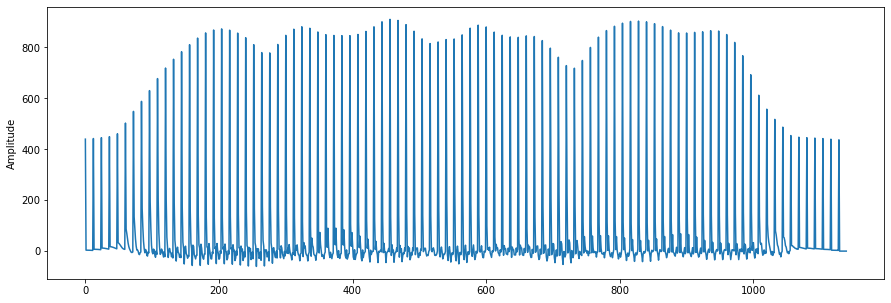

In [3]:
mfcc_flattened = np.reshape(mfcc.T, (mfcc.shape[0] * mfcc.shape[1]))
plt.figure(figsize = (15, 5))
plt.plot(mfcc_flattened)
plt.ylabel('Amplitude')

## 2. Speech emotion recognition

In this section, we will apply the MFCC features to describe speech signals for speech emotion recognition. We will use the dataset EmotionSpeech. This dataset is a part of the Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS).

The folder EmotionSpeech includes two sub-folders: Train and Test. Each Train/Test contains 128 clips (of about 4s) used for training and testing speech emotion recognition models respectively. In each Train/Test folder, there are 4 sub-folders containing audio data for 4 different emotions: calm, happy, sad, and angry. The audio clips for each emotion type are captured by 8 different actors (4 males and 4 females). However, audio clips from the same actor are used for either training or testing (but not both), e.g., clips from the first 4 actors are used for training and clips from the other 4 actors are used for testing. Each actor speaks two statements including "Kids are talking by the door" and "Dogs are sitting by the door".

### We first define emotions and then load the data from audio files to computer memory for further processing:

In [4]:
import os

emotions = ['Calm', 'Happy', 'Sad', 'Angry']
path = 'EmotionSpeech/'
training_file_names = []
training_emotion_labels = []

for i in range(0, len(emotions)):
    sub_path = path + 'Train/' + emotions[i] + '/'
    sub_file_names = [os.path.join(sub_path, f) for f in os.listdir(sub_path)]
    sub_emotion_labels = [i] * len(sub_file_names)
    training_file_names += sub_file_names
    training_emotion_labels += sub_emotion_labels


In [5]:
testing_file_names = []
testing_emotion_labels = []
for i in range(0, len(emotions)):
    sub_path = path + 'Test/' + emotions[i] + '/'
    sub_file_names = [os.path.join(sub_path, f) for f in os.listdir(sub_path)]
    sub_emotion_labels = [i] * len(sub_file_names)
    testing_file_names += sub_file_names
    testing_emotion_labels += sub_emotion_labels

Using the code sample in Section 1, we implement a method, named 'mfcc_extraction' to extract mfcc features from an input audio file. Since audio files may have varying lengths, they would have different numbers of frames (given the same sampling rate is applied). To address this issue, we fix the number of frames in a given input audio clip to a predefined value. Specifically, let num_frames be the variable containing the number of frames. Suppose that an input audio clip has n frames. If n ≥ num_frames, only the first num_frames from the clip will be used. Otherwise, if n < num_frames frames, all the n frames in the clip will be used and the missing frames, i.e., (n+1)-th to num_frames-th frames will be padded by zeros.

In [6]:
import numpy as np
import librosa
from pydub import AudioSegment
from pydub.utils import mediainfo

def mfcc_extraction(audio_filename, #.wav filename
                    hop_duration, #hop_length in seconds, e.g., 0.015s (i.e., 15ms)
                    num_mfcc, #number of mfcc features
                    num_frames #number of frames
                    ):
    speech = AudioSegment.from_wav(audio_filename) #Read audio data from file
    samples = speech.get_array_of_samples() #samples x(t)
    sampling_rate = speech.frame_rate #sampling rate f 
    
    mfcc = librosa.feature.mfcc(
        np.float32(samples),
        sr = sampling_rate,
        hop_length = int(sampling_rate * hop_duration),
        n_mfcc = num_mfcc)
    
    mfcc_truncated = np.zeros((num_mfcc, num_frames), np.float32)
    for i in range(min(num_frames, mfcc.shape[1])):
        mfcc_truncated[:, i] = mfcc[:, i]
        
    #output is a vector including mfcc_truncated.shape[0] * mfcc_truncated.shape[1] elements
    return np.reshape(mfcc_truncated.T, mfcc_truncated.shape[0] * mfcc_truncated.shape[1])

In [7]:
# Create a list of extracted mfcc features
train_mfcc_features = []
test_mfcc_features = []

hop_duration = 0.015
num_frames = 200
num_mfcc = 12

for file_name in training_file_names:
    train_mfcc_features.append(mfcc_extraction(file_name, 
                                                 hop_duration,
                                                 num_mfcc,
                                                 num_frames))

for file_name in testing_file_names:
    test_mfcc_features.append(mfcc_extraction(file_name, 
                                                 hop_duration,
                                                 num_mfcc,
                                                 num_frames))

## Speech emotion recognition using SVM

In [8]:
from sklearn import svm

svm_classifier = svm.SVC(C = 50, kernel = 'linear') 
svm_classifier.fit(np.vstack(train_mfcc_features), np.vstack(training_emotion_labels))

C:\Users\Rahul\Anaconda3\envs\pyenv3.6\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SVC(C=50, kernel='linear')

In [9]:
pred_emotion_labels = svm_classifier.predict(np.vstack(test_mfcc_features))

In [10]:
from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score

print(classification_report(np.vstack(testing_emotion_labels), pred_emotion_labels, target_names=emotions))

              precision    recall  f1-score   support

        Calm       0.64      0.91      0.75        32
       Happy       0.63      0.38      0.47        32
         Sad       0.52      0.69      0.59        32
       Angry       0.82      0.56      0.67        32

    accuracy                           0.63       128
   macro avg       0.65      0.63      0.62       128
weighted avg       0.65      0.63      0.62       128



Overall accuracy : 0.6328125


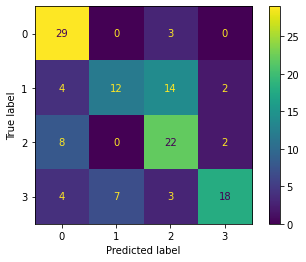

In [11]:
plot_confusion_matrix(svm_classifier, np.vstack(test_mfcc_features), np.vstack(testing_emotion_labels))

print ("Overall accuracy : {}".format(accuracy_score(np.vstack(testing_emotion_labels), pred_emotion_labels)))

### Vary num_mfcc in the range [12, 14, 16, 18, 20, 22, 24, 26, 28, 30] and report the corresponding overall recognition accuracies:

In [14]:
def eval_svm(num_mfcc):

    # Create a list of extracted mfcc features
    train_mfcc_features = []
    test_mfcc_features = []
    hop_duration = 0.015
    num_frames = 200
    num_mfcc = num_mfcc

    for file_name in training_file_names:
        train_mfcc_features.append(mfcc_extraction(file_name, 
                                                     hop_duration,
                                                     num_mfcc,
                                                     num_frames))

    for file_name in testing_file_names:
        test_mfcc_features.append(mfcc_extraction(file_name, 
                                                     hop_duration,
                                                     num_mfcc,
                                                     num_frames))
        
    svm_model = svm.SVC(C=50, kernel='linear')
    
    start = time.time()
    svm_model.fit(np.vstack(train_mfcc_features), np.vstack(training_emotion_labels))
    end = time.time()
    
    train_time = end - start
    
    start = time.time()
    pred_emotion_labels = svm_model.predict(np.vstack(test_mfcc_features))
    end = time.time()
    
    test_time = end - start
    
    print(classification_report(np.vstack(testing_emotion_labels), pred_emotion_labels, target_names=emotions))
    
    plot_confusion_matrix(svm_model, np.vstack(test_mfcc_features), np.vstack(testing_emotion_labels))
    
    print ("overall accuracy : {}".format(accuracy_score(np.vstack(testing_emotion_labels), pred_emotion_labels)))
    
    return accuracy_score(np.vstack(testing_emotion_labels), pred_emotion_labels), train_time, test_time

C:\Users\Rahul\Anaconda3\envs\pyenv3.6\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


              precision    recall  f1-score   support

        Calm       0.64      0.91      0.75        32
       Happy       0.63      0.38      0.47        32
         Sad       0.52      0.69      0.59        32
       Angry       0.82      0.56      0.67        32

    accuracy                           0.63       128
   macro avg       0.65      0.63      0.62       128
weighted avg       0.65      0.63      0.62       128

overall accuracy : 0.6328125


C:\Users\Rahul\Anaconda3\envs\pyenv3.6\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


              precision    recall  f1-score   support

        Calm       0.64      0.91      0.75        32
       Happy       0.63      0.38      0.47        32
         Sad       0.52      0.69      0.59        32
       Angry       0.82      0.56      0.67        32

    accuracy                           0.63       128
   macro avg       0.65      0.63      0.62       128
weighted avg       0.65      0.63      0.62       128

overall accuracy : 0.6328125


C:\Users\Rahul\Anaconda3\envs\pyenv3.6\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


              precision    recall  f1-score   support

        Calm       0.63      0.91      0.74        32
       Happy       0.63      0.38      0.47        32
         Sad       0.54      0.69      0.60        32
       Angry       0.82      0.56      0.67        32

    accuracy                           0.63       128
   macro avg       0.65      0.63      0.62       128
weighted avg       0.65      0.63      0.62       128

overall accuracy : 0.6328125


C:\Users\Rahul\Anaconda3\envs\pyenv3.6\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


              precision    recall  f1-score   support

        Calm       0.63      0.91      0.74        32
       Happy       0.63      0.38      0.47        32
         Sad       0.54      0.69      0.60        32
       Angry       0.82      0.56      0.67        32

    accuracy                           0.63       128
   macro avg       0.65      0.63      0.62       128
weighted avg       0.65      0.63      0.62       128

overall accuracy : 0.6328125


C:\Users\Rahul\Anaconda3\envs\pyenv3.6\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


              precision    recall  f1-score   support

        Calm       0.63      0.91      0.74        32
       Happy       0.67      0.44      0.53        32
         Sad       0.56      0.69      0.62        32
       Angry       0.82      0.56      0.67        32

    accuracy                           0.65       128
   macro avg       0.67      0.65      0.64       128
weighted avg       0.67      0.65      0.64       128

overall accuracy : 0.6484375


C:\Users\Rahul\Anaconda3\envs\pyenv3.6\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


              precision    recall  f1-score   support

        Calm       0.63      0.91      0.74        32
       Happy       0.65      0.41      0.50        32
         Sad       0.55      0.69      0.61        32
       Angry       0.82      0.56      0.67        32

    accuracy                           0.64       128
   macro avg       0.66      0.64      0.63       128
weighted avg       0.66      0.64      0.63       128

overall accuracy : 0.640625


C:\Users\Rahul\Anaconda3\envs\pyenv3.6\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


              precision    recall  f1-score   support

        Calm       0.63      0.91      0.74        32
       Happy       0.65      0.41      0.50        32
         Sad       0.55      0.69      0.61        32
       Angry       0.82      0.56      0.67        32

    accuracy                           0.64       128
   macro avg       0.66      0.64      0.63       128
weighted avg       0.66      0.64      0.63       128

overall accuracy : 0.640625


C:\Users\Rahul\Anaconda3\envs\pyenv3.6\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


              precision    recall  f1-score   support

        Calm       0.60      0.91      0.72        32
       Happy       0.65      0.41      0.50        32
         Sad       0.53      0.62      0.57        32
       Angry       0.82      0.56      0.67        32

    accuracy                           0.62       128
   macro avg       0.65      0.62      0.62       128
weighted avg       0.65      0.62      0.62       128

overall accuracy : 0.625


C:\Users\Rahul\Anaconda3\envs\pyenv3.6\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


              precision    recall  f1-score   support

        Calm       0.62      0.94      0.75        32
       Happy       0.62      0.41      0.49        32
         Sad       0.53      0.62      0.57        32
       Angry       0.81      0.53      0.64        32

    accuracy                           0.62       128
   macro avg       0.64      0.62      0.61       128
weighted avg       0.64      0.62      0.61       128

overall accuracy : 0.625


C:\Users\Rahul\Anaconda3\envs\pyenv3.6\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


              precision    recall  f1-score   support

        Calm       0.61      0.94      0.74        32
       Happy       0.65      0.41      0.50        32
         Sad       0.51      0.59      0.55        32
       Angry       0.82      0.56      0.67        32

    accuracy                           0.62       128
   macro avg       0.65      0.62      0.61       128
weighted avg       0.65      0.62      0.61       128

overall accuracy : 0.625


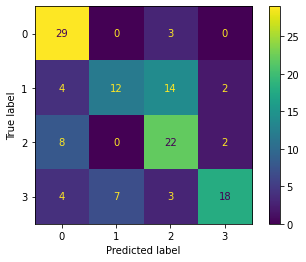

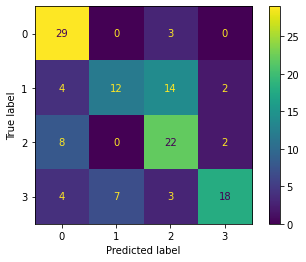

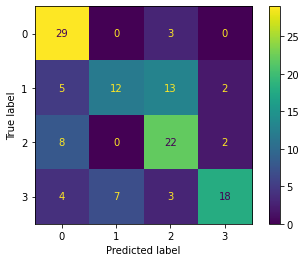

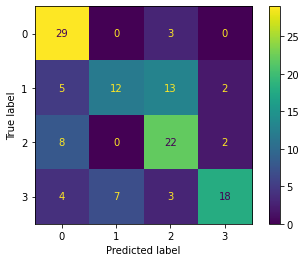

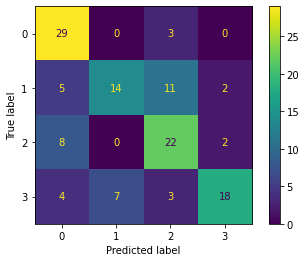

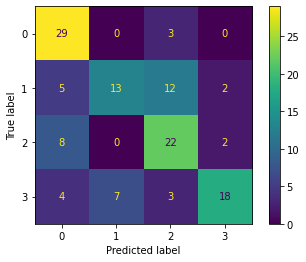

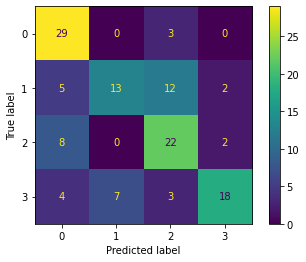

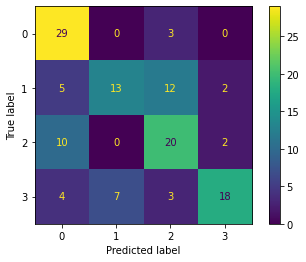

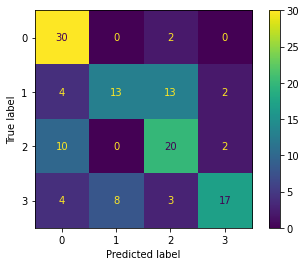

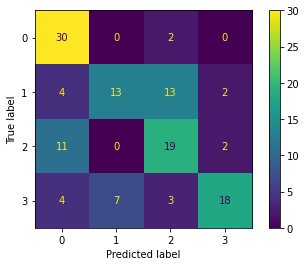

In [15]:
num_mfccs = [12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
svm_accuracy = []
train_time_svm = []
test_time_svm = []
for num_mfcc in num_mfccs:
    accuracy, train_time, test_time = eval_svm(num_mfcc)
    svm_accuracy.append(accuracy)
    train_time_svm.append(train_time)
    test_time_svm.append(test_time)

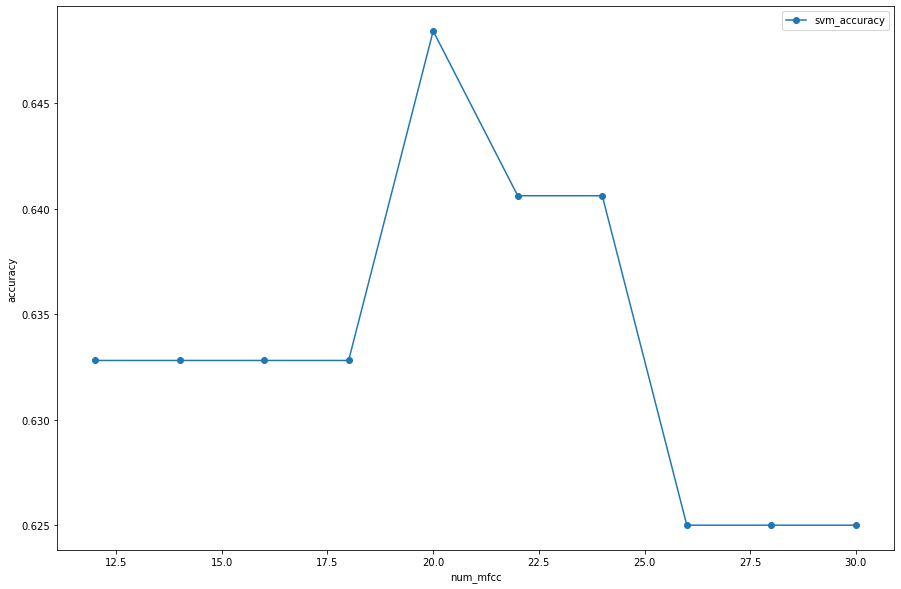

In [18]:
plt.figure(figsize=(15, 10))
plt.plot(num_mfccs, svm_accuracy, marker="o", label='svm_accuracy')
plt.xlabel('num_mfcc')
plt.ylabel('accuracy')
plt.legend()

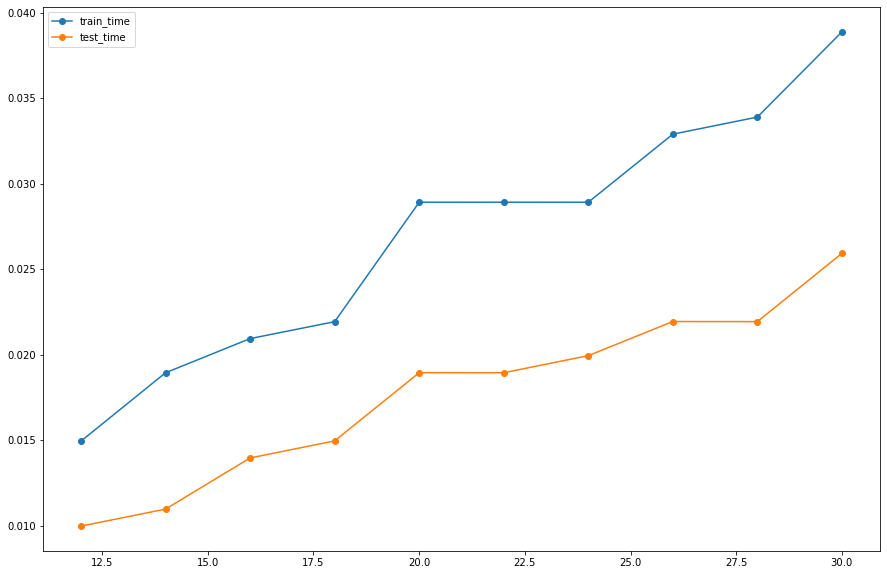

In [19]:
plt.figure(figsize=(15, 10))
plt.plot(num_mfccs, train_time_svm, marker="o", label="train_time")
plt.plot(num_mfccs, test_time_svm, marker="o", label="test_time")
plt.legend()

## Speech emotion recognition using AdaBoost:

In [22]:
from sklearn.ensemble import AdaBoostClassifier

def eval_adaboost(num_mfcc):

    # Create a list of extracted mfcc features
    train_mfcc_features = []
    test_mfcc_features = []
    hop_duration = 0.015
    num_frames = 200
    num_mfcc = num_mfcc

    for file_name in training_file_names:
        train_mfcc_features.append(mfcc_extraction(file_name, 
                                                     hop_duration,
                                                     num_mfcc,
                                                     num_frames))

    for file_name in testing_file_names:
        test_mfcc_features.append(mfcc_extraction(file_name, 
                                                     hop_duration,
                                                     num_mfcc,
                                                     num_frames))
        
    ada_model = AdaBoostClassifier(n_estimators=100)
    
    start = time.time()
    ada_model.fit(np.vstack(train_mfcc_features), np.vstack(training_emotion_labels))
    end = time.time()
    
    train_time = end - start
    
    start = time.time()
    pred_emotion_labels = ada_model.predict(np.vstack(test_mfcc_features))
    end = time.time()
    
    test_time = end - start
    
    print(classification_report(np.vstack(testing_emotion_labels), pred_emotion_labels, target_names=emotions))
    
    plot_confusion_matrix(ada_model, np.vstack(test_mfcc_features), np.vstack(testing_emotion_labels))
    
    print ("overall accuracy : {}".format(accuracy_score(np.vstack(testing_emotion_labels), pred_emotion_labels)))
    
    return accuracy_score(np.vstack(testing_emotion_labels), pred_emotion_labels), train_time, test_time


C:\Users\Rahul\Anaconda3\envs\pyenv3.6\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


              precision    recall  f1-score   support

        Calm       0.56      0.84      0.68        32
       Happy       0.22      0.06      0.10        32
         Sad       0.26      0.31      0.29        32
       Angry       0.61      0.62      0.62        32

    accuracy                           0.46       128
   macro avg       0.41      0.46      0.42       128
weighted avg       0.41      0.46      0.42       128

overall accuracy : 0.4609375


C:\Users\Rahul\Anaconda3\envs\pyenv3.6\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


              precision    recall  f1-score   support

        Calm       0.44      0.97      0.60        32
       Happy       0.14      0.03      0.05        32
         Sad       0.12      0.09      0.11        32
       Angry       0.62      0.50      0.55        32

    accuracy                           0.40       128
   macro avg       0.33      0.40      0.33       128
weighted avg       0.33      0.40      0.33       128

overall accuracy : 0.3984375


C:\Users\Rahul\Anaconda3\envs\pyenv3.6\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


              precision    recall  f1-score   support

        Calm       0.51      0.84      0.64        32
       Happy       0.00      0.00      0.00        32
         Sad       0.18      0.31      0.23        32
       Angry       0.61      0.34      0.44        32

    accuracy                           0.38       128
   macro avg       0.32      0.38      0.33       128
weighted avg       0.32      0.38      0.33       128

overall accuracy : 0.375


C:\Users\Rahul\Anaconda3\envs\pyenv3.6\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


              precision    recall  f1-score   support

        Calm       0.58      0.81      0.68        32
       Happy       0.33      0.03      0.06        32
         Sad       0.23      0.47      0.31        32
       Angry       0.88      0.44      0.58        32

    accuracy                           0.44       128
   macro avg       0.51      0.44      0.41       128
weighted avg       0.51      0.44      0.41       128

overall accuracy : 0.4375


C:\Users\Rahul\Anaconda3\envs\pyenv3.6\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


              precision    recall  f1-score   support

        Calm       0.49      0.75      0.59        32
       Happy       0.12      0.03      0.05        32
         Sad       0.18      0.31      0.23        32
       Angry       0.44      0.22      0.29        32

    accuracy                           0.33       128
   macro avg       0.31      0.33      0.29       128
weighted avg       0.31      0.33      0.29       128

overall accuracy : 0.328125


C:\Users\Rahul\Anaconda3\envs\pyenv3.6\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


              precision    recall  f1-score   support

        Calm       0.57      0.84      0.68        32
       Happy       0.50      0.09      0.16        32
         Sad       0.28      0.50      0.36        32
       Angry       0.83      0.47      0.60        32

    accuracy                           0.48       128
   macro avg       0.55      0.48      0.45       128
weighted avg       0.55      0.48      0.45       128

overall accuracy : 0.4765625


C:\Users\Rahul\Anaconda3\envs\pyenv3.6\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


              precision    recall  f1-score   support

        Calm       0.60      0.81      0.69        32
       Happy       0.38      0.09      0.15        32
         Sad       0.32      0.44      0.37        32
       Angry       0.64      0.66      0.65        32

    accuracy                           0.50       128
   macro avg       0.48      0.50      0.46       128
weighted avg       0.48      0.50      0.46       128

overall accuracy : 0.5


C:\Users\Rahul\Anaconda3\envs\pyenv3.6\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


              precision    recall  f1-score   support

        Calm       0.53      0.84      0.65        32
       Happy       0.40      0.06      0.11        32
         Sad       0.30      0.38      0.33        32
       Angry       0.59      0.59      0.59        32

    accuracy                           0.47       128
   macro avg       0.46      0.47      0.42       128
weighted avg       0.46      0.47      0.42       128

overall accuracy : 0.46875


C:\Users\Rahul\Anaconda3\envs\pyenv3.6\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


              precision    recall  f1-score   support

        Calm       0.50      0.84      0.63        32
       Happy       0.11      0.03      0.05        32
         Sad       0.21      0.38      0.27        32
       Angry       0.67      0.19      0.29        32

    accuracy                           0.36       128
   macro avg       0.37      0.36      0.31       128
weighted avg       0.37      0.36      0.31       128

overall accuracy : 0.359375


C:\Users\Rahul\Anaconda3\envs\pyenv3.6\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


              precision    recall  f1-score   support

        Calm       0.47      0.81      0.60        32
       Happy       0.14      0.03      0.05        32
         Sad       0.25      0.41      0.31        32
       Angry       0.53      0.25      0.34        32

    accuracy                           0.38       128
   macro avg       0.35      0.38      0.33       128
weighted avg       0.35      0.38      0.33       128

overall accuracy : 0.375


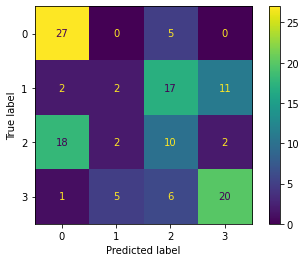

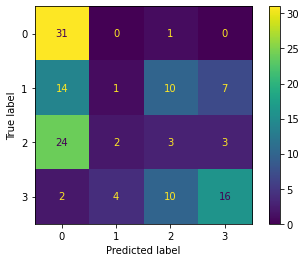

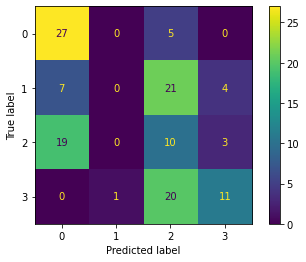

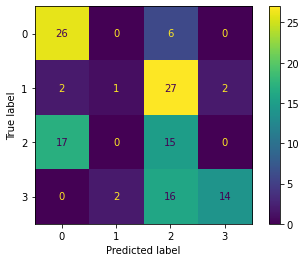

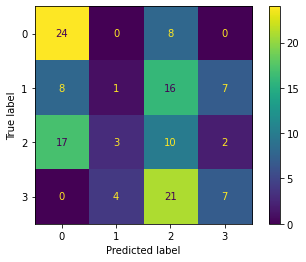

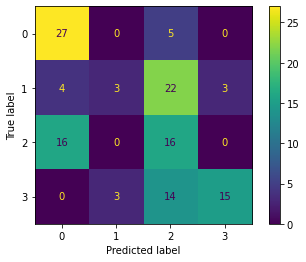

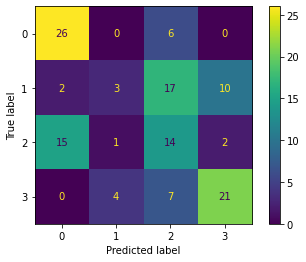

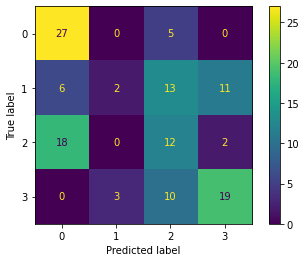

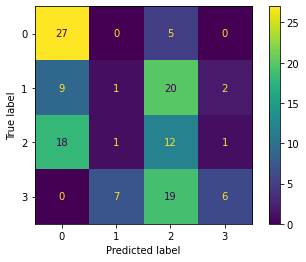

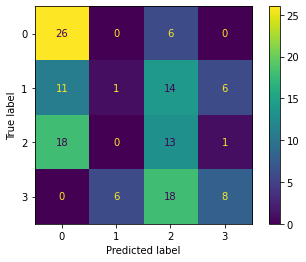

In [23]:
num_mfccs = [12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
ada_accuracy = []
train_time_ada = []
test_time_ada = []
for num_mfcc in num_mfccs:
    accuracy, train_time, test_time = eval_adaboost(num_mfcc)
    ada_accuracy.append(accuracy)
    train_time_ada.append(train_time)
    test_time_ada.append(test_time)

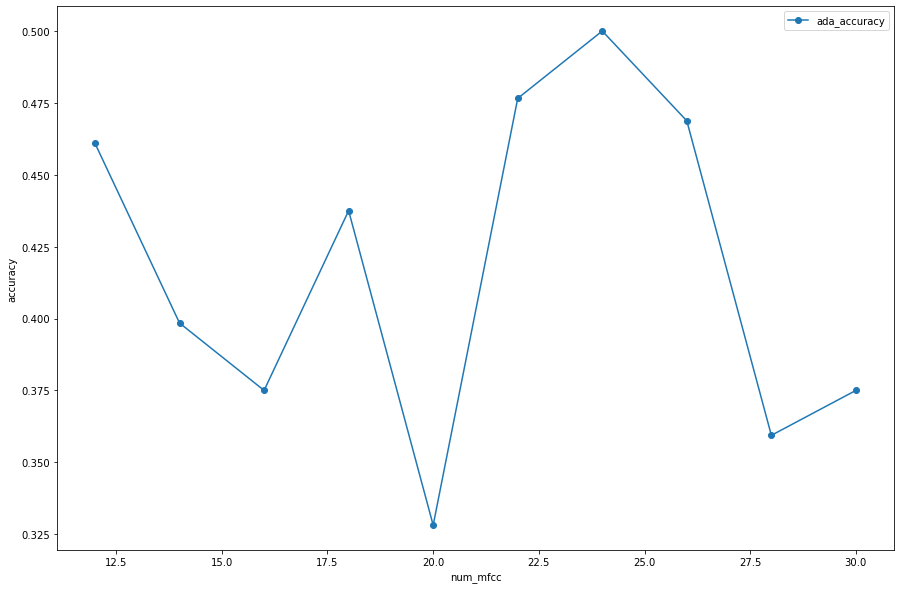

In [25]:
plt.figure(figsize=(15, 10))
plt.plot(num_mfccs, ada_accuracy, marker="o", label="ada_accuracy")
plt.xlabel('num_mfcc')
plt.ylabel('accuracy')
plt.legend()

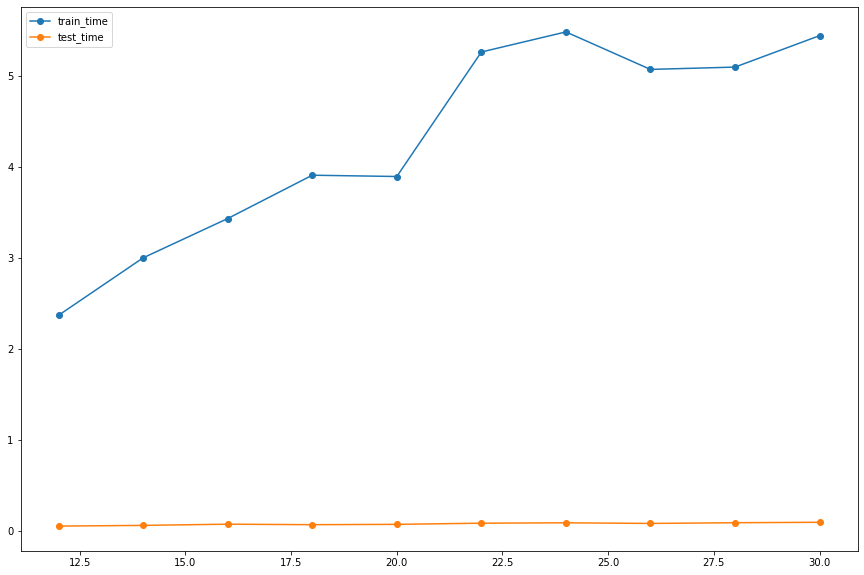

In [26]:
plt.figure(figsize=(15, 10))
plt.plot(num_mfccs, train_time_ada, marker="o", label="train_time")
plt.plot(num_mfccs, test_time_ada, marker="o", label="test_time")
plt.legend()

In [27]:
print("SVM Train time:", train_time_svm)

SVM Train time: [0.014947175979614258, 0.018947601318359375, 0.020944833755493164, 0.02193427085876465, 0.028921842575073242, 0.028923511505126953, 0.028922319412231445, 0.03290367126464844, 0.0339045524597168, 0.03888750076293945]


In [28]:
print("SVM Test Time:", test_time_svm)

SVM Test Time: [0.009976625442504883, 0.010970354080200195, 0.0139617919921875, 0.014961004257202148, 0.018950223922729492, 0.01894855499267578, 0.019946575164794922, 0.021944046020507812, 0.02193927764892578, 0.02593064308166504]


In [29]:
print("Ada Train time:", train_time_ada)

Ada Train time: [2.3667025566101074, 2.997514247894287, 3.4288721084594727, 3.904871940612793, 3.8905837535858154, 5.258083820343018, 5.478831052780151, 5.066952705383301, 5.092421531677246, 5.437443494796753]


In [30]:
print("Ada Test time:", test_time_ada)

Ada Test time: [0.05083012580871582, 0.05844283103942871, 0.0718536376953125, 0.06629014015197754, 0.06993770599365234, 0.08281683921813965, 0.08691644668579102, 0.07992768287658691, 0.0877695083618164, 0.09275436401367188]


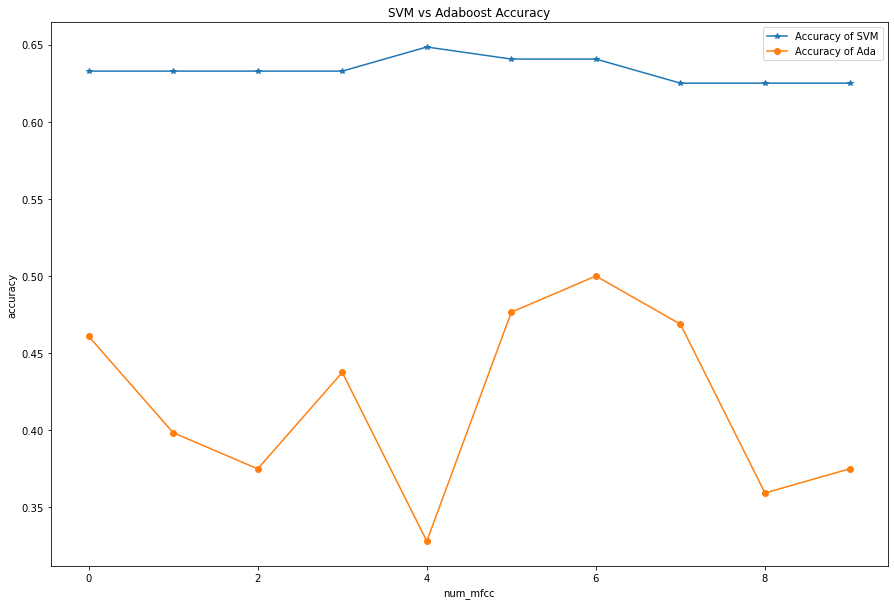

In [31]:
plt.figure(figsize=(15, 10))
plt.title('SVM vs Adaboost Accuracy')
plt.plot(svm_accuracy, marker='*', label='Accuracy of SVM')
plt.plot(ada_accuracy, marker='o', label="Accuracy of Ada")
plt.xlabel('num_mfcc')
plt.ylabel('accuracy')
plt.legend()

**After evaluating both SVM and AdaBoost we can conclude that, SVM model performed better in terms of accuracy (overall 64.84%) with num_mfcc value of 20 while AdaBooost achieved an overall accuracy of 50% with num_mfcc of 24.**

**In terms of training and testing time, SVM performed better as it took only 0.0289s for training and 0.0189s for testing while AdaBoost took more time, 5.4788s for training and 0.0869s for testing.**  